## Import libraries

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from mlrefined_libraries import convnets_library as convlib
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import superlearn_library as superlearn

import autograd.numpy as np
from autograd.util import flatten_func
from autograd import grad as compute_grad   

import autograd.numpy as np
import pandas as pd
import cv2
import csv
import pickle
import glob
import time

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

In [219]:
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':            
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

<IPython.core.display.Javascript object>


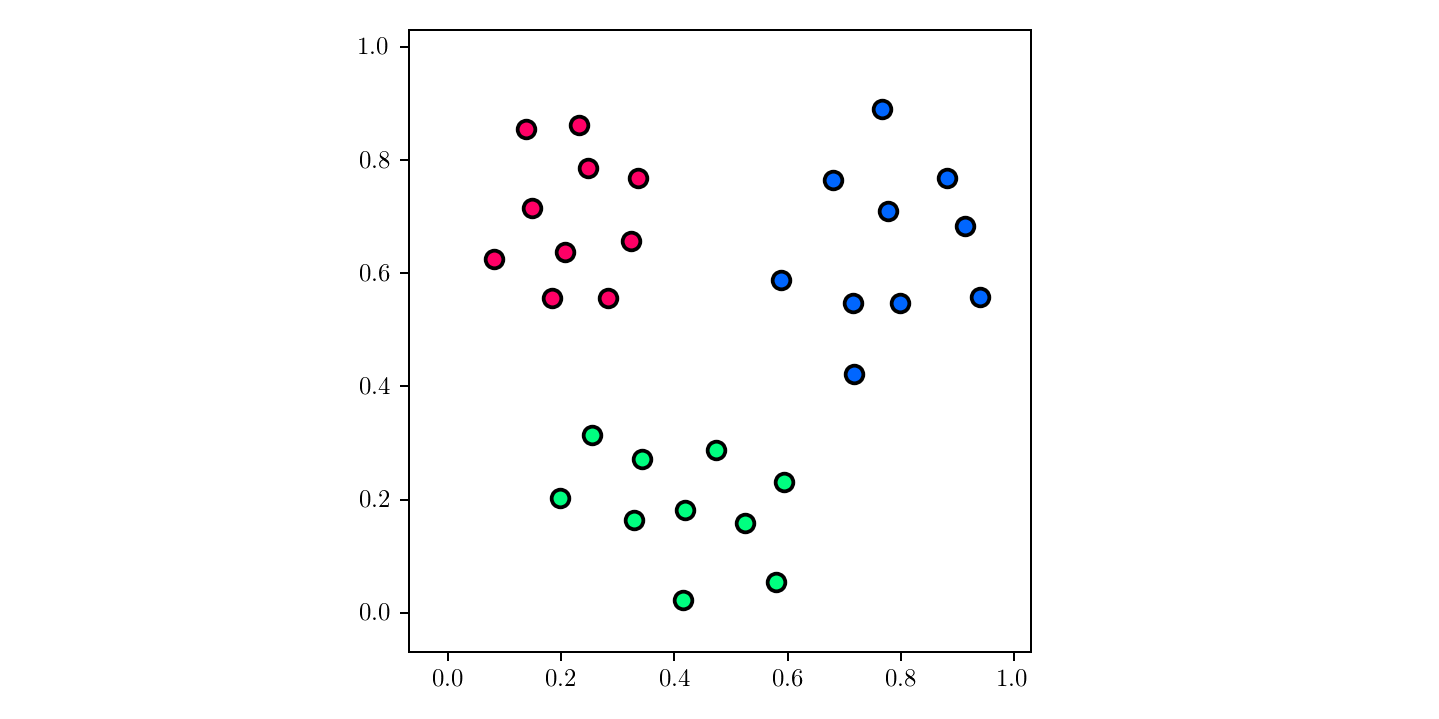

In [3]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo = superlearn.multiclass_illustrator.Visualizer(data)

# visualize dataset
demo.show_dataset()

In [4]:
# define the input and output of our dataset
x = np.asarray(data[:,:-1])
x.shape = (len(x),np.shape(data)[1]-1); x = x.T;
y = data[:,-1]
y.shape = (len(y),1)
y = [int(v) - 1 for v in y]

# COMPACT MULTICLASS COST

In [5]:
# multiclass softmaax regularized by the summed length of all normal vectors
lam = 10**-3  # our regularization paramter 
def multiclass_softmax_compact(W):        
    # pre-compute predictions on all points
    all_evals = W[0,:] + np.dot(x.T,W[1:,:])
    
    # compute cost in compact form using numpy
    cost = np.sum(np.log(np.sum(np.exp(all_evals),axis = 1) - all_evals[np.arange(len(y)),y]) )
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(W[1:,:],'fro')**2
    return cost

In [6]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
W_init = np.random.randn(3,3)
w_hist = opt.gradient_descent(g = multiclass_softmax_compact,w = W_init,version = 'unnormalized',max_its = 400, alpha = 10**-1)

<IPython.core.display.Javascript object>


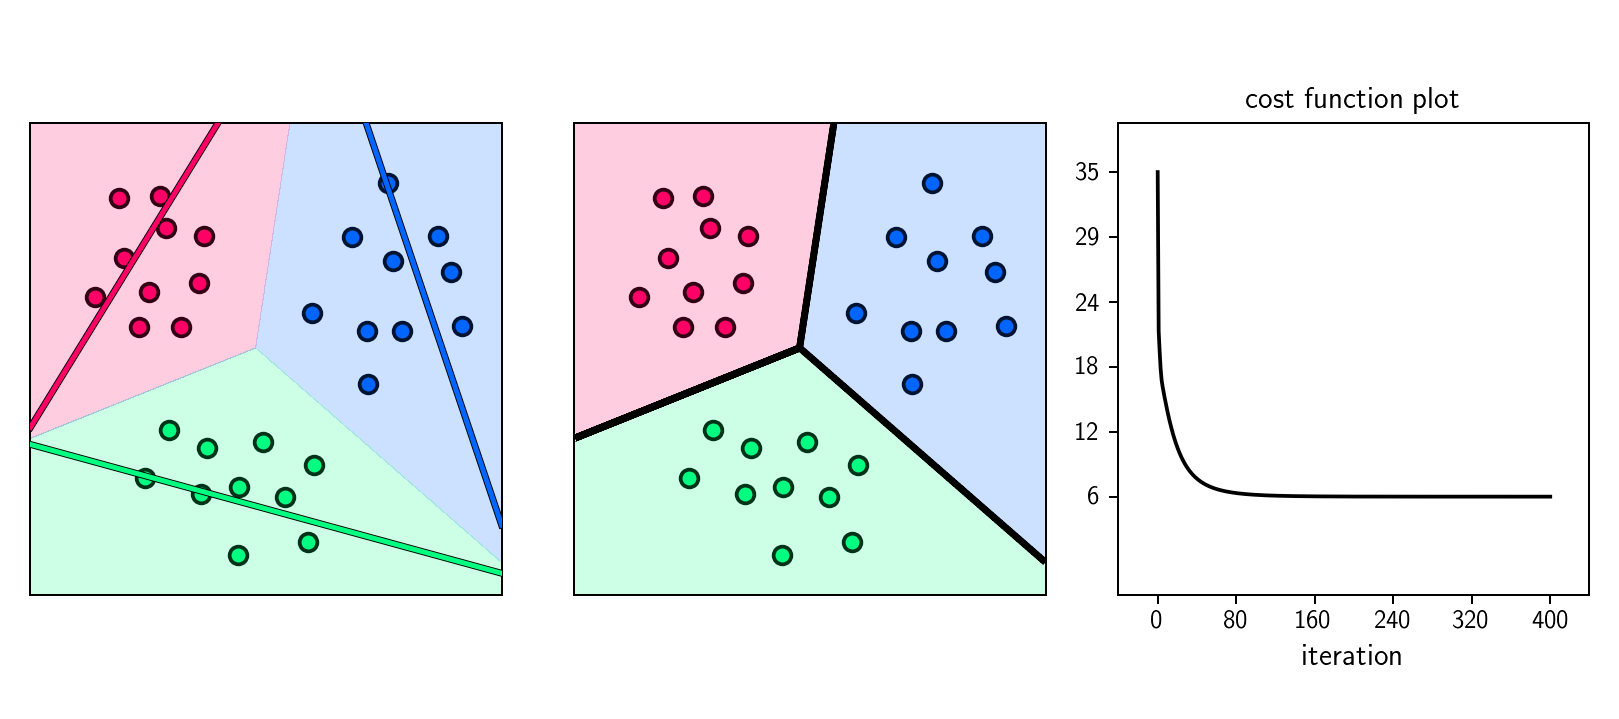

In [7]:
# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(w_hist,show_cost = True, cost = multiclass_softmax_compact)

<IPython.core.display.Javascript object>


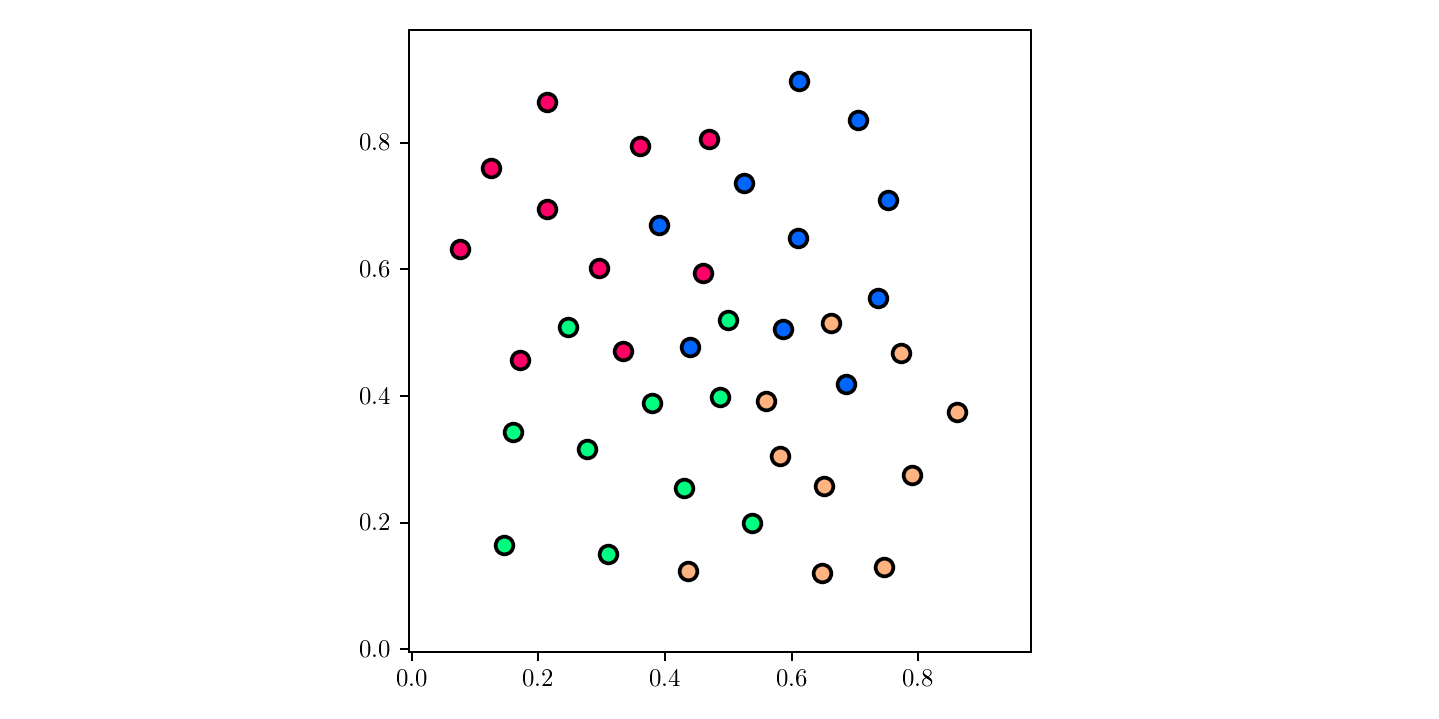

In [8]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/4class_data.csv',delimiter = ',')

# create an instance of the ova demo
demo = superlearn.multiclass_illustrator.Visualizer(data)

# visualize dataset
demo.show_dataset()

In [9]:
# define the input and output of our dataset
x = np.asarray(data[:,:-1])
x.shape = (len(x),np.shape(data)[1]-1); x = x.T;
y = data[:,-1]
y.shape = (len(y),1)
y = [int(v) - 1 for v in y]

In [10]:
np.shape(x)

(2, 40)

In [11]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
W_init = np.random.randn(3,4)
w_hist = opt.gradient_descent(g = multiclass_softmax_compact,w = W_init,version = 'unnormalized',max_its = 400, alpha = 10**-1)

<IPython.core.display.Javascript object>


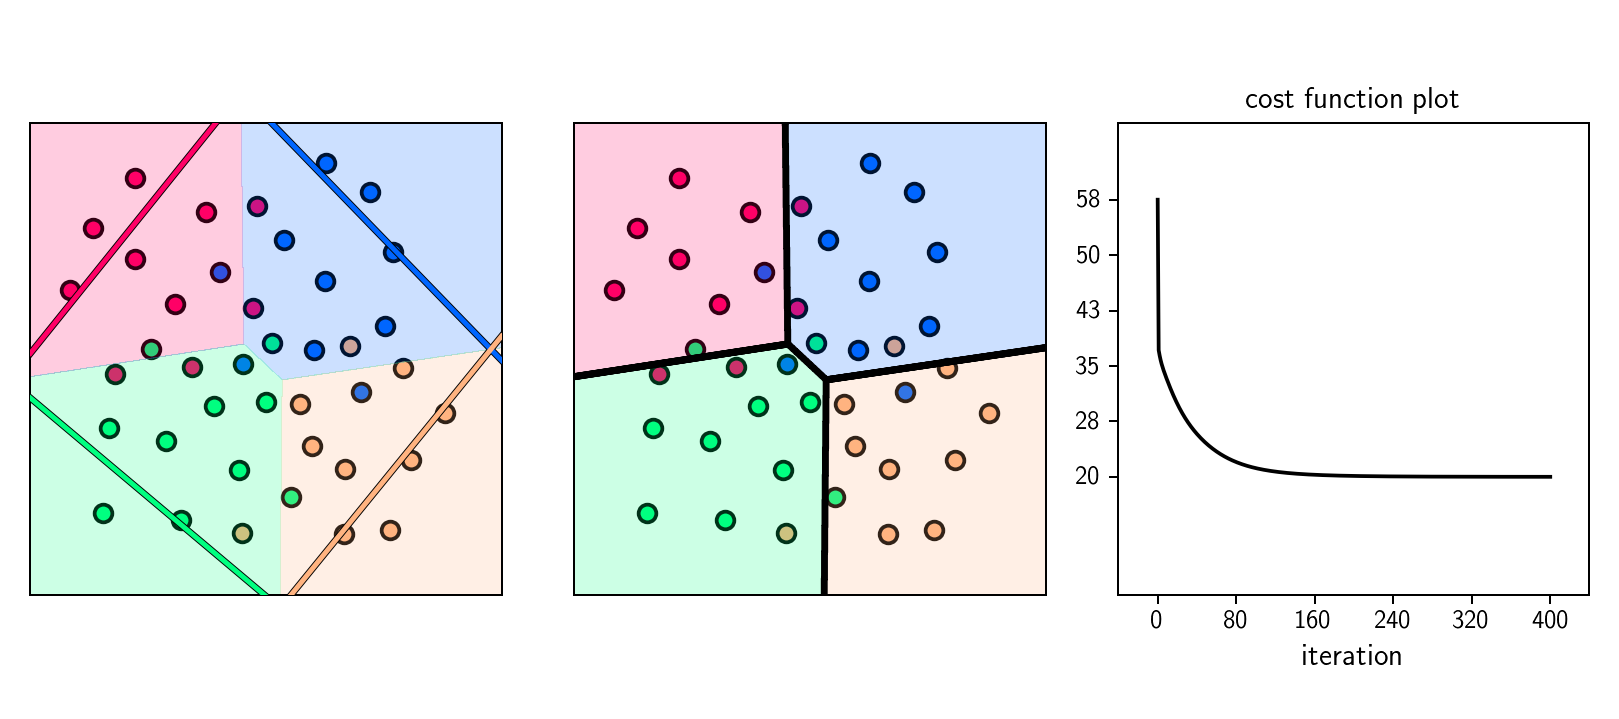

In [12]:
# plot classification of space, individual learned classifiers (left panel) and joint boundary (middle panel), and cost-function panel in the right panel
demo.show_complete_coloring(w_hist,show_cost = True, cost = multiclass_softmax_compact)

In [13]:
# flatten the input function, create gradient based on flat function
g_flat, unflatten, w = flatten_func(multiclass_softmax_compact, W_init)
grad = compute_grad(g_flat)

# plug in value into func and derivative
grad_eval = grad(w)
grad_eval.shape = np.shape(w)

unflatten(grad_eval)

array([[ 21.19243844,   0.72717657,  -0.18348704,   3.98036418],
       [ 10.54830957,  -0.08281148,   0.15593677,   1.09498924],
       [ 10.40599455,   0.04123417,   0.21209972,   2.62652874]])

# MNIST sample set

In [42]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

def plot_history(train_data,test_data,weight_history):
    '''
    fusion rule for counting number of misclassifications on an input multiclass dataset
    '''
    
    # initialize figure
    fig = plt.figure(figsize = (9,3))

    # create subplot with 3 panels, plot input function in center plot
    gs = gridspec.GridSpec(1, 2) 
    ax1 = plt.subplot(gs[0]); 
    ax2 = plt.subplot(gs[1]);
    
    # loop over training/testing data
    for data in [train_data,test_data]:
        # get input/utput
        x = data[:,1:]
        y = data[:,0]
        y = [int(v) for v in y]
        
        # de-contrast data
        x_decontrast = de_contrast(x.T).T
    
        # loop over input weight history and create associated cost and misclassification histories
        cost_history = []
        count_history = []
        for W in weight_history:
            ####### compute cost value ######
            # pad input x with ones
            all_evals = predict(x_decontrast,W)

            # compute cost in compact form using numpy
            cost = np.sum(np.log(np.sum(np.exp(all_evals),axis = 1) - all_evals[np.arange(len(y)),y]))
            cost_history.append(cost)

            ####### compute count #######
            # create predicted labels
            y_predict = np.argmax(all_evals,axis = 1) 

            # compare to actual labels
            misclassifications = np.sum(np.sign(y - y_predict)**2)
            count_history.append(misclassifications)

        # now plot each, one per panel
        ax1.plot(cost_history)  
        ax2.plot(count_history)

    # label graphs
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('cost function val')
    ax1.set_title('cost function history')
    
    ax2.set_xlabel('iteration')
    ax2.set_ylabel('misclassifications')
    ax2.set_title('number of misclassificaions')
    
    # put on
    ax2.legend(['training','testing'],loc='upper right')
    
    plt.show()
    
    # find the best misclassification rate in this run of gradient descent and print explicitly
    ind_best = np.argmin(count_history)
    weight_best = weight_history[ind_best]
    count_best = int(count_history[ind_best])
    print ('the lowest number of misclassifications on test set we achieved from this run was = ' + str(count_best) + ' at step ' + str(ind_best))
    
    return weight_best

# our predict function 
def predict_testing_1(x,w):     
    # feature trasnsformations
    f,stats = compute_features_normalized_testing(x,w[0],training_stats_1)
    
    # compute linear model
    vals = np.dot(f,w[1])
    return vals

In [15]:
datapath = '../../../../../Desktop/mnist/'

In [74]:
# load in dataset
data = np.loadtxt(datapath + 'mnist_mini_train.csv',delimiter = ',')

# make training and testing set
train_data = data[:4000,:]
x_train = train_data[:,1:]
y_train = train_data[:,0]
y_train = [int(v) for v in y_train]

test_data = data[4000:,:]
x_test = test_data[:,1:]
y_test = test_data[:,0]
y_test = [int(v) for v in y_test]

## Normalize data - both de-contrast and feature normalize

In [75]:
# our normalization function
def de_contrast(data):
    data_means = np.mean(data,axis = 0)
    data = data - data_means
    data_stds = np.std(data,axis = 0)
    data = data/data_stds
    return data

# normalize the input 
x_decontrast = de_contrast(x_train.T).T

In [44]:
# our normalization function
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/(data_std + 10**(-5))
    return normalized_data

# compute the mean and standard deviation of our input, then normalize the input
x_means = np.mean(x_decontrast,axis = 0)
x_stds = np.std(x_decontrast,axis = 0)

# normalize the input data
x_normed = normalize(x_decontrast,x_means,x_stds)

## softmax cost function

In [76]:
# multiclass softmaax regularized by the summed length of all normal vectors
def multiclass_softmax_compact(W):
    # get predict vals
    all_evals = predict(x_decontrast,W)
    
    # compute cost
    cost = np.sum(np.log(np.sum(np.exp(all_evals),axis = 1) - all_evals[np.arange(len(y_train)),y_train]))  
    
    # return
    return cost

## Linear predictor

In [77]:
def predict(x,W):
    # pre-compute predictions on all points
    all_evals = W[0,:] + np.dot(x,W[1:,:])
    return all_evals

In [85]:
C = len(np.unique(y_train))
P,N = np.shape(x_train)
scale = 0.01
w_init = scale*np.random.randn(N+1,C)

In [104]:
# parameters of gradient descent
version = 'unnormalized'
alpha =  10**(-6)
max_its = 1000;
beta = 0; 

# run gradient descent, create cost history (for cost function plot comparison) associated with output weight history
weight_history_1 = gradient_descent(multiclass_softmax_compact,w_init,alpha,max_its,beta,version = version)

<IPython.core.display.Javascript object>


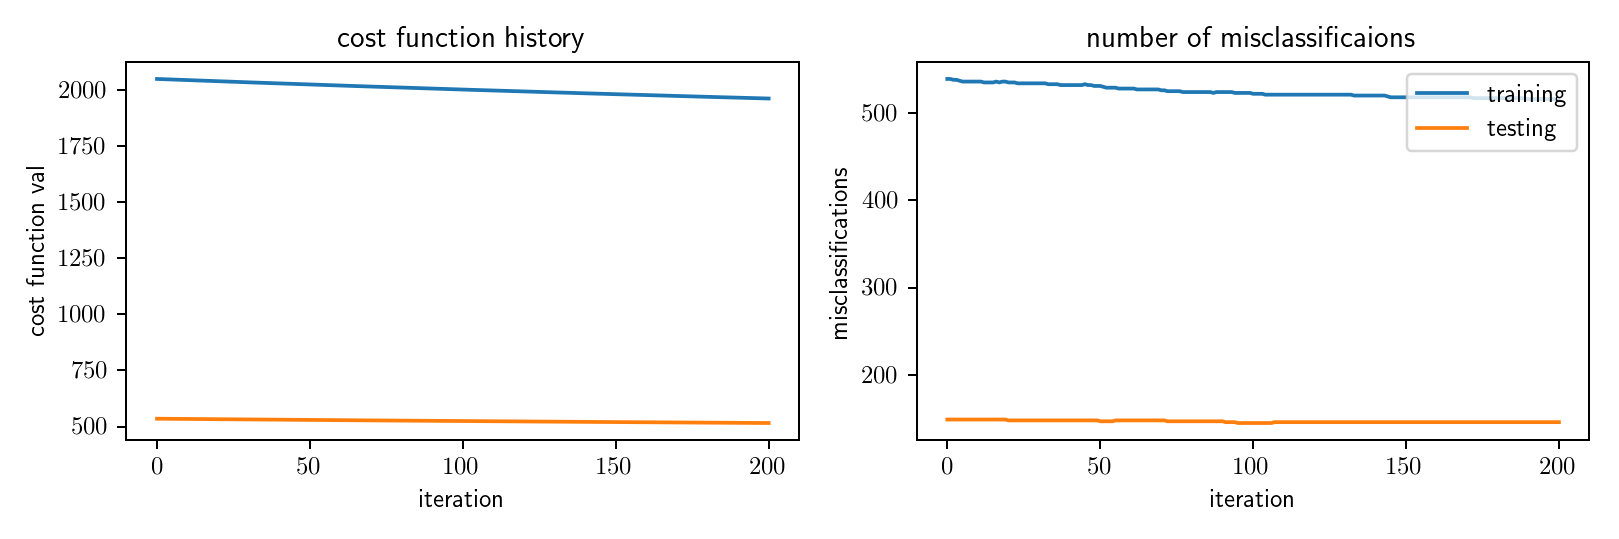

the lowest number of misclassifications on test set we achieved from this run was = 145 at step 95


In [106]:
weight_best =  plot_history(train_data,test_data,weight_history_1[800:])

## Network fit

In [167]:
def compute_features_normalized_testing(x, inner_weights,stats):
    '''
    An adjusted normalized architecture compute function that collects network statistics as the training data
    passes through each layer, and applies them to properly normalize test data.
    '''
    # are you using this to compute stats on training data (stats empty) or to normalize testing data (stats not empty)
    switch =  'testing'
    if np.size(stats) == 0:
        switch = 'training'
        
    # if no stats given collect directly from input
    x_means = 0
    y_means = 0
    if switch == 'training':
        x_means = np.mean(x,axis = 0)
        x_stds = np.std(x,axis = 0)
        stats.append([x_means,x_stds])
    elif switch == 'testing':
        x_means = stats[0][0]
        x_stds = stats[0][1]

    # normalize input
    x_normed = normalize(x,x_means,x_stds)
    
    # pad data with ones to deal with bias
    o = np.ones((np.shape(x_normed)[0],1))
    a_padded = np.concatenate((o,x_normed),axis = 1)
        
    # loop through weights and update each layer of the network
    c = 1
    for W1,W2 in inner_weights:                                    ###### THIS LINE WAS CHANGED FROM THE ORIGINAL #####
        # output of layer activation
        a = activation(np.dot(a_padded,W1),np.dot(a_padded,W2))    ###### THIS LINE WAS CHANGED FROM THE ORIGINAL #####
                
        ### normalize output of activation
        a_means = 0
        a_stds = 0
        if switch == 'training':
            # compute the mean and standard deviation of the activation output distributions
            a_means = np.mean(a,axis = 0)
            a_stds = np.std(a,axis = 0)
            stats.append([a_means,a_stds])
        elif switch == 'testing':
            a_means = stats[c][0]
            a_stds = stats[c][1]
            
        # normalize the activation outputs
        a_normed = normalize(a,a_means,a_stds)
            
        # pad with ones for bias
        o = np.ones((np.shape(a_normed)[0],1))
        a_padded = np.concatenate((o,a_normed),axis = 1)
        c+=1
    
    return a_padded,stats

In [168]:
# create initial weights for arbitrary feedforward network
def initialize_network_weights(layer_sizes,scale):
    # container for entire weight tensor
    weights = []
    
    # loop over desired layer sizes and create appropriately sized initial 
    # weight matrix for each layer
    for k in range(len(layer_sizes)-1):
        # get layer sizes for current weight matrix
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k+1]

        # make weight matrix
        weight1 = scale*np.random.randn(U_k + 1,U_k_plus_1)
        
        # add second matrix for inner weights
        if k < len(layer_sizes)-2:
            weight2 = scale*np.random.randn(U_k + 1,U_k_plus_1)
            weights.append([weight1,weight2])
        else:
            weights.append(weight1)

    # re-express weights so that w_init[0] = omega_inner contains all 
    # internal weight matrices, and w_init = w contains weights of 
    # final linear combination in predict function
    w_init = [weights[:-1],weights[-1]]
    
    return w_init

In [169]:
# make training and testing set
train_data = data[:4000,:]
x_train = train_data[:,1:]
y_train = train_data[:,0]
y_train = [int(v) for v in y_train]

# normalize the input 
x_decontrast = de_contrast(x_train.T).T

In [220]:
# A 5 layer network architecture
N = np.shape(x_train)[1]
M = len(np.unique(y_train))
U_1 = 50                # number of units in layer 1
U_2 = 50                # number of units in layer 2
U_3 = 50                # number of units in layer 3
U_4 = 50                # number of units in layer 4
U_5 = 50                # number of units in layer 4

# the list defines our network architecture
layer_sizes = [N,U_1,U_2,U_3,U_4,U_5,M]

# generate initial weights for our network
w_init = initialize_network_weights(layer_sizes,scale = 0.01)

In [221]:
# our normalization function
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/(data_std + 10**(-5))
    return normalized_data

In [222]:
# compute the mean and standard deviation of our input, then normalize the input
x_means = np.mean(x_decontrast,axis = 0)
x_stds = np.std(x_decontrast,axis = 0)

# normalize the input data
x_normed = normalize(x_decontrast,x_means,x_stds)

In [223]:
def activation(t1,t2):
    # maxout activation
    f = np.maximum(t1,t2)
    return f

In [224]:
def compute_features_normalized(x, inner_weights):
    # pad data with ones to deal with bias
    o = np.ones((np.shape(x)[0],1))
    a_padded = np.concatenate((o,x),axis = 1)
        
    # loop through weights and update each layer of the network
    for W1,W2 in inner_weights:                                  ###### THIS LINE WAS CHANGED FROM THE ORIGINAL #####
        # output of layer activation  
        a = activation(np.dot(a_padded,W1),np.dot(a_padded,W2))  ###### THIS LINE WAS CHANGED FROM THE ORIGINAL #####
                
        ### normalize output of activation
        # compute the mean and standard deviation of the activation output distributions
        a_means = np.mean(a,axis = 0)
        a_stds = np.std(a,axis = 0)
        
        # normalize the activation outputs
        a_normed = normalize(a,a_means,a_stds)
            
        # pad with ones for bias
        o = np.ones((np.shape(a_normed)[0],1))
        a_padded = np.concatenate((o,a_normed),axis = 1)
    
    return a_padded

In [225]:
# our predict function 
def predict(x,w):     
    # feature trasnsformations
    f = compute_features_normalized(x,w[0])
    
    # compute linear model
    vals = np.dot(f,w[1])
    return vals

# multiclass softmaax regularized by the summed length of all normal vectors
def multiclass_softmax_compact(W):
    # get predict vals
    all_evals = predict(x_normed,W)
    
    # compute cost
    cost = np.sum(np.log(np.sum(np.exp(all_evals),axis = 1) - all_evals[np.arange(len(y_train)),y_train])) # + lam*np.linalg.norm(W[1:,:],'fro')**2
    
    # return
    return cost

In [236]:
# parameters of gradient descent
version = 'normalized'
alpha =  3*10**(-1)
max_its = 100;
beta = 0; 

# run gradient descent, create cost history (for cost function plot comparison) associated with output weight history
weight_history_1 = gradient_descent(multiclass_softmax_compact,w_init,alpha,max_its,beta,version = version)

<IPython.core.display.Javascript object>


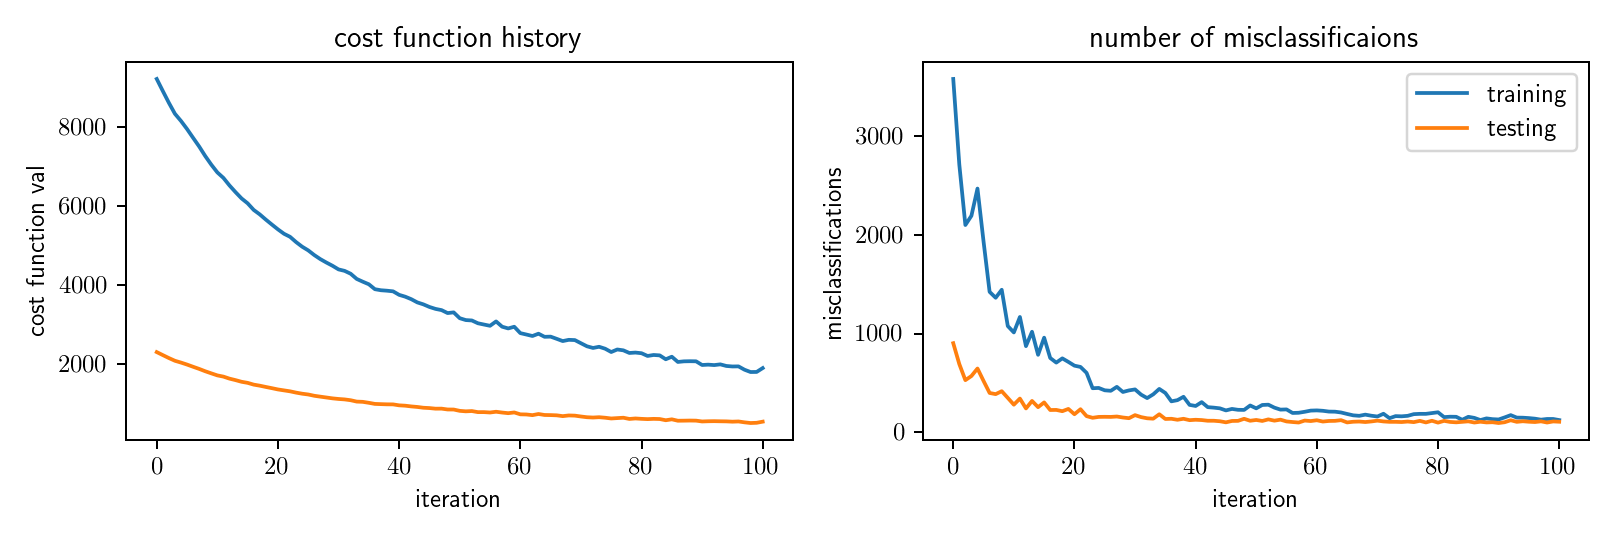

the lowest number of misclassifications on test set we achieved from this run was = 92 at step 90


In [238]:
weight_best =  plot_history(train_data,test_data,weight_history_1[0:])

# load data

In [10]:
 def load_data(csvname):
    # load in data
    data = np.asarray(pd.read_csv(csvname))

    # import data and reshape appropriately
    X = data[:,0:-1]
    y = data[:,-1]
    y.shape = (len(y),1)
    
    X_square = np.zeros((len(y),28,28))
    for i in range(0,len(y)):
        X_square[i,:,:] = np.reshape(X[i,:],(28,28),1)
    
    # pad data with ones for more compact gradient computation
    o = np.ones((np.shape(X)[0],1))
    X = np.concatenate((o,X),axis = 1)
    X = X.T
    
    return X,X_square,y

In [11]:
# load data
X,X_square, y = load_data('../../mlrefined_datasets/convnet_datasets/feat_face_data.csv')

KeyboardInterrupt: 

## Extract features 

In [ ]:
# create HOG-like features for data

# load kernels
kernels = convlib.image_viz.load_kernels()
#kernels = convlib.image_viz.load_kernels_v2(8,(3,3))

# params
sliding_window_size= (6,6) 
stride=3
pooling_func= 'max'
#normalization = 'l2'

# get number of images in the dataset
num_images = np.shape(X_square)[0]
        
# a test run to find the number of features with the params above
test = convlib.image_viz.make_feat(X_square[0,:,:], kernels, sliding_window_size=sliding_window_size, stride=stride)
num_features = np.shape(test)[0]

                
feat = np.zeros((num_features,num_images))
for i in range(0,num_images):
    # extract features
    feat[:,i] = convlib.image_viz.make_feat(X_square[i,:,:], kernels, sliding_window_size=sliding_window_size,
                                            stride=stride, pooling_func=pooling_func)

# uncomment to pad features with ones (if needed)
#feat = np.concatenate((np.ones((1,num_images)),feat))          

In [ ]:
print('number of images: ', np.shape(y)[0])
print('number of raw pixels: ', np.shape(X)[0])
print('number of HOG features: ', np.shape(feat)[0])

In [ ]:
# split into train/test
X_train = np.concatenate((X[:,0:2000],X[:,2999:8000]),1)
feat_train = np.concatenate((feat[:,0:2000],feat[:,2999:8000]),1)
y_train = np.concatenate((y[0:2000],y[2999:8000]))

X_test = np.concatenate((X[:,2000:2999],X[:,8000:10000]),1)
feat_test = np.concatenate((feat[:,2000:2999],feat[:,8000:10000]),1)
y_test = np.concatenate((y[2000:2999],y[8000:10000]))

## Classification

In [ ]:
###### for squared margin cost #######
# function for computing gradient and Hessian for squared margin cost Newton's method
def squared_margin_grad_hess(X, y, w):
    hess = 0
    grad = 0
    for p in range(0,len(y)):
        # precompute        
        x_p = X[:,p]
        y_p = y[p]
        
        # update grad and hessian
        grad+= -2*max(0,1 - y_p*np.dot(x_p.T,w))*y_p*x_p
        
        if 1 - y_p*np.dot(x_p.T,w) > 0:
            hess+= 2*np.outer(x_p,x_p)
        
    grad.shape = (len(grad),1)
    return grad,hess

# run newton's method
def squared_margin_newtons_method(X_train, y_train, w, X_test, y_test):
    # begin newton's method loop    
    max_its = 20
    misclass_history = []
    for k in range(max_its):
        # compute gradient and Hessian
        grad,hess = squared_margin_grad_hess(X_train, y_train, w)

        # take Newton step
        hess = hess + 10**-3*np.diag(np.ones((np.shape(X_train)[0])))
        temp = np.dot(hess,w) - grad        
        w = np.dot(np.linalg.pinv(hess),temp)

        # update history container
        cost = count_misclasses(w, X_test, y_test)
        misclass_history.append(cost)
        
        print('iteration:',k+1, ' of ', max_its)
    
    return misclass_history

In [ ]:
# function for counting the number of misclassifications
def count_misclasses(w, X, y):
    y_pred = np.sign(np.dot(X.T,w))
    num_misclassed = len(y) - len([i for i, j in zip(y, y_pred) if i == j])
    return num_misclassed

In [ ]:
###### raw pixels #######
w0 = np.random.randn(np.shape(X_train)[0],1)
squared_margin_history_raw = squared_margin_newtons_method(X_train, y_train, w0, X_test, y_test)

In [ ]:
###### HOG #######
w0 = np.random.randn(np.shape(feat)[0],1)
squared_margin_history_HOG = squared_margin_newtons_method(feat_train, y_train, w0, feat_test, y_test)

In [ ]:
# plot results
plt.plot(squared_margin_history_raw,color = 'm', linewidth=3)
plt.plot(squared_margin_history_HOG,'k', linewidth=3)

# clean up plot
plt.ylim([0,400])
plt.xlabel('iteration of Newtons method')
plt.ylabel('number of misclassifications')
plt.legend(['raw','my HOG'])
plt.show()